In [22]:
import pandas as pd

In [23]:
# Load the data
df = pd.read_csv("weather_data.csv")

In [24]:
# Generate time-based features
df['hour'] = pd.to_datetime(df['dt'],unit='s').dt.hour
df['month'] = pd.to_datetime(df['dt'],unit='s').dt.month

# Generate target temperature feature (Max temperature of the next 24 hours)
df['temp_target'] = df['temp'].shift(-1).rolling(24).max()

# Generate lag features (e.g., temperature 1 hour ago)
df['temp_lag_1'] = df['temp'].shift(1)
df['temp_lag_3'] = df['temp'].shift(3)

In [25]:
parsed_df = df[
    [
        'dt','dt_iso','timezone','city_name','lat','lon','temp','humidity','pressure','hour','month','temp_target','temp_lag_1','temp_lag_3'
    ]
]

In [26]:
parsed_df = parsed_df.dropna()

In [27]:
parsed_df

,dt,dt_iso,timezone,city_name,lat,lon,temp,humidity,pressure,hour,month,temp_target,temp_lag_1,temp_lag_3
23,1072998000,2004-01-01 23:00:00 +0000 UTC,3600,Stockholm,59.329323,18.068581,-7.13,85,1029,23,1,-2.25,-6.93,-6.35
24,1073001600,2004-01-02 00:00:00 +0000 UTC,3600,Stockholm,59.329323,18.068581,-7.57,88,1029,0,1,-2.38,-7.13,-6.10
25,1073005200,2004-01-02 01:00:00 +0000 UTC,3600,Stockholm,59.329323,18.068581,-7.18,85,1029,1,1,-2.56,-7.57,-6.93
26,1073008800,2004-01-02 02:00:00 +0000 UTC,3600,Stockholm,59.329323,18.068581,-7.67,92,1030,2,1,-2.56,-7.18,-7.13
27,1073012400,2004-01-02 03:00:00 +0000 UTC,3600,Stockholm,59.329323,18.068581,-8.36,87,1030,3,1,-2.76,-7.67,-7.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183835,1723399200,2024-08-11 18:00:00 +0000 UTC,7200,Stockholm,59.329323,18.068581,20.43,56,1009,18,8,22.06,20.71,21.82
183836,1723402800,2024-08-11 19:00:00 +0000 UTC,7200,Stockholm,59.329323,18.068581,18.29,62,1009,19,8,22.06,20.43,21.71
183837,1723406400,2024-08-11 20:00:00 +0000 UTC,7200,Stockholm,59.329323,18.068581,17.32,74,1010,20,8,22.06,18.29,20.71
183838,1723410000,2024-08-11 21:00:00 +0000 UTC,7200,Stockholm,59.329323,18.068581,15.59,82,1010,21,8,22.06,17.32,20.43


In [28]:
parsed_df.to_csv("processed_weather_data.csv", index=False)

In [29]:
%pip install xgboost==2.1.1

Note: you may need to restart the kernel to use updated packages.


In [30]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import xgboost as xgb
import joblib

In [31]:
# Load the processed data
df = pd.read_csv("processed_weather_data.csv")

In [32]:
# Feature selection
X = df[['hour', 'month', 'temp','humidity','pressure','temp_lag_1','temp_lag_3']]
y = df['temp_target']

In [33]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
# XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [35]:
# Model evaluation
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.2f}°C")
rmse = sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse:.2f}°C")

Mean Absolute Error: 1.43°C
Root Mean Squared Error: 1.89°C


In [36]:
model.predict(X.iloc[[-480]])

array([24.102488], dtype=float32)

In [37]:
y.iloc[[-480]]

183337    22.63
Name: temp_target, dtype: float64

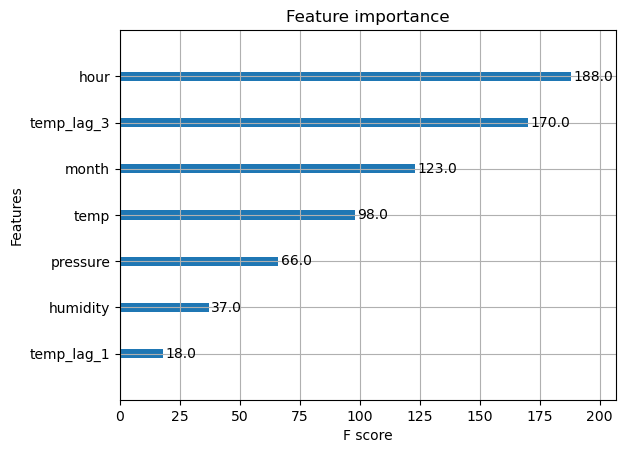

In [38]:
#Examine feature importance to determine which features can be pruned
import matplotlib.pyplot as plt

xgb.plot_importance(model)
plt.show()

In [39]:
booster = model.get_booster()
booster.feature_names = list(X.columns) 
booster.save_model("model.bst")

c:\Users\m_was\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:08:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [40]:
# Save the model
#joblib.dump(model, "weather_forecasting_model_stockholm_xgb.pkl")

In [41]:
#Load the model
#model = joblib.load("weather_forecasting_model_stockholm_xgb.pkl")

In [42]:
# Predict with a mock sample (using trained XGBRegressor)
# Run this after training so `model` and `X` are defined
import pandas as pd

mock = {
    'hour': 14,
    'month': 9,
    'temp': 18.0,
    'humidity': 55.0,
    'pressure': 1012.0,
    'temp_lag_1': 17.5,
    'temp_lag_3': 16.8,
}

X_mock = pd.DataFrame([mock]).reindex(columns=X.columns)
pred = model.predict(X_mock)
print(f"Mock prediction (next-24h max temp): {float(pred[0]):.2f}°C")

# Option: using the saved booster in a fresh session
# booster = xgb.Booster()
# booster.load_model("model.bst")
# y_hat = booster.predict(xgb.DMatrix(X_mock))
# print(f"Mock prediction (booster): {float(y_hat[0]):.2f}°C")


Mock prediction (next-24h max temp): 18.61°C
